<a href="https://colab.research.google.com/github/lkhart/kaggle_dogs_vs_cats/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dogs vs. Cats Redux: Kernels Edition**

#### [Kaggle Competition Entry](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)/Class Assignment 
#### Laura Hart - MSDS 422 - Winter 2022

The objective of this exercise is to apply classification techniques to correctly identify whether an animal in an image is a cat or dog. Images have different backgrounds and different breeds of cats/dogs represented.

## Management/Research Question: Practical Application
Image classification can be applied in a number of practical cases, including autonomous vehicles identifying pedestrians vs. other cars, or agricultural application equipment identifying whether a plant is a weed or crop. 

### Setup

In [60]:
from google.colab import files
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import sklearn.model_selection
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import clear_output

In [2]:
# using kaggle API to download data
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
# kaggle.json file uploaded manually
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 50.7MB/s]
 98% 533M/544M [00:03<00:00, 145MB/s]
100% 544M/544M [00:03<00:00, 155MB/s]
 95% 259M/271M [00:03<00:00, 103MB/s] 
100% 271M/271M [00:03<00:00, 86.3MB/s]


In [7]:
from IPython.core.display import clear_output
! unzip train.zip
clear_output()

In [8]:
! unzip test.zip
clear_output()

### Exploratory Data Analysis

Explore data to understand distribution of categories and format of data.

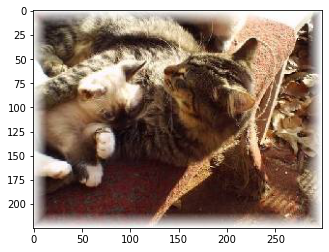

In [3]:
# show random image from dataset
filenames = os.listdir("./train")
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

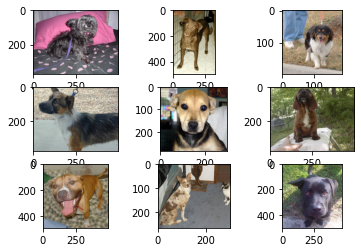

In [10]:
# show first few images from Dog label

for i in range(9):
  plt.subplot(330+1+i)
  filename = os.path.join('train', 'dog.'+str(i)+'.jpg')
  image = imread(filename)
  plt.imshow(image)

plt.show()

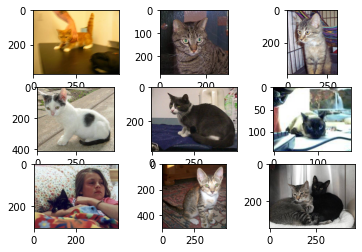

In [11]:
# show first few images from Cat label

for i in range(9):
  plt.subplot(330+1+i)
  filename = os.path.join('train', 'cat.'+str(i)+'.jpg')
  image = imread(filename)
  plt.imshow(image)

plt.show()

Determine how many images of each category are present in training data

In [12]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
  category = filename.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

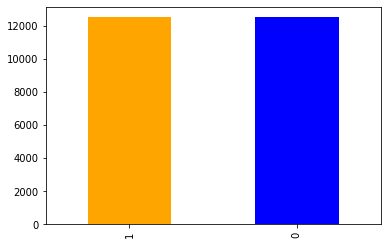

In [ ]:
df['category'].value_counts().plot.bar(color=['orange', 'blue'])

The training set contains an equal number of cat images and dog images; no special sampling technique will be required when splitting the data into train and validation sets. 

### Data Prep

In [23]:
def create_train_data(path):
    X = []
    y = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (128, 128))
        img_arr = img_arr / 255.0
        cat = np.where(img.split('.')[0] == 'dog', 1, 0)
        
        X.append(img_arr)
        y.append(cat)
            
    X = np.array(X).reshape(-1, 128, 128, 1)
    y = np.array(y)
    
    return X, y  

In [24]:
def create_test_data(path):
    X = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (128, 128))
        img_arr = img_arr / 255.0
        
        X.append(img_arr)
            
    X = np.array(X).reshape(-1, 128, 128, 1)
    
    return X

In [25]:
train_dir = '/content/train'

In [26]:
X, y = create_train_data(train_dir)

In [27]:
ycat = keras.utils.to_categorical(y, 2)

In [28]:
# set seed for reproducibility
np.random.seed(123)
# train-val split
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, ycat, test_size=0.2)

In [29]:
test_dir = '/content/test'

In [30]:
X_test = create_test_data(test_dir)

In [17]:
# # reshape labels as 2D tensor
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

In [31]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(20000, 128, 128, 1)
(5000, 128, 128, 1)
(20000, 2)
(5000, 2)


### Modeling

We will build 3 CNN models to evaluate. 

#### Model 1

Model 1 has only one convolutional layer with 32 filters and one max pooling layer. I am implementing an early stopping measure that will stop the model training if the val_loss metric does not improve for 2 consecutive epochs.

In [32]:
model1 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [33]:
# add early stopping - max 2 epochs without improvement in score
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [34]:
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [35]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 127008)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               16257152  
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 16,257,730
Trainable params: 16,257,730
Non-trainable params: 0
__________________________________________

In [41]:
history = model1.fit(X_train, y_train, epochs=10,
                             validation_data=(X_val, y_val),
                             callbacks=[callback])

Epoch 1/10
625/625 [==============================] - 142s 227ms/step - loss: 0.2898 - accuracy: 0.8779 - val_loss: 0.6406 - val_accuracy: 0.7268
Epoch 2/10
625/625 [==============================] - 136s 218ms/step - loss: 0.1815 - accuracy: 0.9305 - val_loss: 0.7822 - val_accuracy: 0.7298
Epoch 3/10
625/625 [==============================] - 136s 217ms/step - loss: 0.1012 - accuracy: 0.9661 - val_loss: 0.9045 - val_accuracy: 0.7196


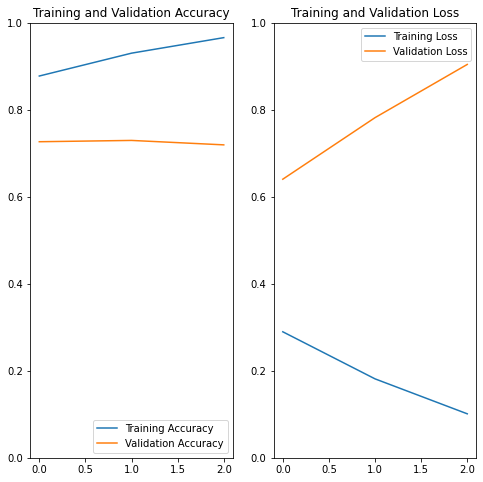

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.gca().set_ylim(0,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.gca().set_ylim(0,1)
plt.show()

In [45]:
probability_model_1 = tf.keras.Sequential([model1, tf.keras.layers.Softmax()])

In [52]:
ypred1 = probability_model_1.predict(X_val)

In [54]:
ypred1_list = []
for i in range(0, len(ypred1)):
    ypred1_list.append(np.argmax(ypred1[i]))

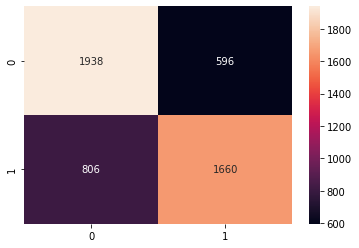

In [55]:
# confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), ypred1_list)
sns.heatmap(cm, annot=True, fmt='d')

In [56]:
print(classification_report(np.argmax(y_val, axis=1), ypred1_list))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      2534
           1       0.74      0.67      0.70      2466

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [57]:
# test predictions
test_pred1 = probability_model_1.predict(X_test)

In [58]:
test_pred1_list = []
for i in range(0, len(test_pred1)):
    test_pred1_list.append(test_pred1[i][0])

In [61]:
Id = []
for i in range(1, len(test_pred1_list) + 1):
    Id.append(i)

m1_sub = pd.DataFrame(list(zip(Id, test_pred1_list)), columns = ['id', 'label'])
m1_sub.to_csv('submission1.csv', index = False)
files.download('submission1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

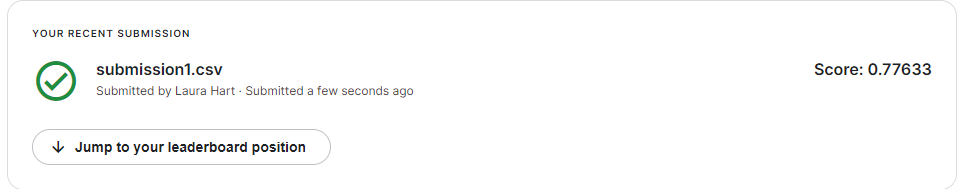

As indicated by the confusion matrix and ultimately the poor performance on the final test data, this model was not very successful in distinguishing between dog and cat images. Performance against the validation data was better than what we saw when submitting the model. 

#### Model 2

Model 2 has 3 convolutional layers with 128 filters and 3 max pooling layers. I am implementing an early stopping measure that will stop the model training if the val_loss metric does not improve for 2 consecutive epochs.

In [62]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [63]:
# add early stopping - max 2 epochs without improvement in score
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [64]:
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [65]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)     

In [66]:
history = model2.fit(X_train, y_train, epochs=10,
                             validation_data=(X_val, y_val),
                             callbacks=[callback])

Epoch 1/10
625/625 [==============================] - 362s 579ms/step - loss: 0.5865 - accuracy: 0.6776 - val_loss: 0.5458 - val_accuracy: 0.7216
Epoch 2/10
625/625 [==============================] - 328s 525ms/step - loss: 0.4680 - accuracy: 0.7793 - val_loss: 0.4341 - val_accuracy: 0.7970
Epoch 3/10
625/625 [==============================] - 328s 525ms/step - loss: 0.4044 - accuracy: 0.8169 - val_loss: 0.3920 - val_accuracy: 0.8212
Epoch 4/10
625/625 [==============================] - 329s 526ms/step - loss: 0.3380 - accuracy: 0.8513 - val_loss: 0.3797 - val_accuracy: 0.8316
Epoch 5/10
625/625 [==============================] - 328s 525ms/step - loss: 0.2700 - accuracy: 0.8838 - val_loss: 0.3665 - val_accuracy: 0.8428
Epoch 6/10
625/625 [==============================] - 332s 531ms/step - loss: 0.2005 - accuracy: 0.9209 - val_loss: 0.4517 - val_accuracy: 0.8256
Epoch 7/10
625/625 [==============================] - 333s 532ms/step - loss: 0.1344 - accuracy: 0.9471 - val_loss: 0.4765 -

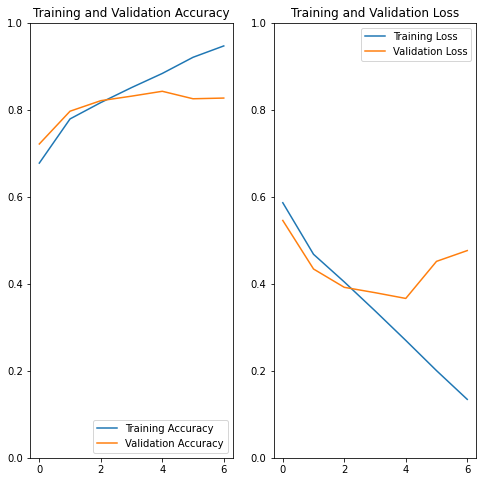

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.gca().set_ylim(0,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.gca().set_ylim(0,1)
plt.show()

In [70]:
probability_model_2 = tf.keras.Sequential([model2, tf.keras.layers.Softmax()])

In [71]:
ypred2 = probability_model_2.predict(X_val)

In [72]:
ypred2_list = []
for i in range(0, len(ypred2)):
    ypred2_list.append(np.argmax(ypred2[i]))

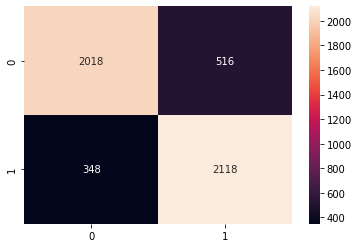

In [73]:
# confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), ypred2_list)
sns.heatmap(cm, annot=True, fmt='d')

In [78]:
print(classification_report(np.argmax(y_val, axis=1), ypred2_list))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      2534
           1       0.80      0.86      0.83      2466

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [75]:
# test predictions
test_pred2 = probability_model_2.predict(X_test)

In [76]:
test_pred2_list = []
for i in range(0, len(test_pred2)):
    test_pred2_list.append(test_pred2[i][0])

In [77]:
Id = []
for i in range(1, len(test_pred2_list) + 1):
    Id.append(i)

m2_sub = pd.DataFrame(list(zip(Id, test_pred2_list)), columns = ['id', 'label'])
m2_sub.to_csv('submission2.csv', index = False)
files.download('submission2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

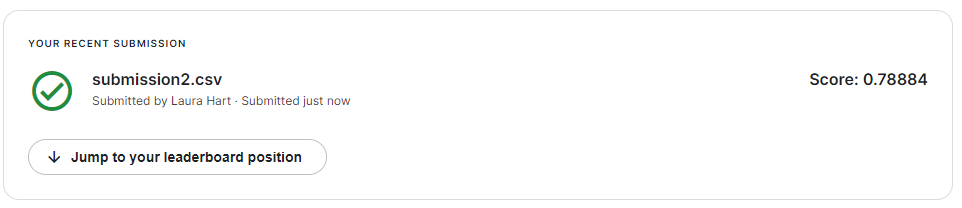

#### Model 3

Model 3 has 4 convolutional layers with 256 filters and 4 max pooling layers. I am implementing an early stopping measure that will stop the model training if the val_loss metric does not improve for 2 consecutive epochs.

In [79]:
model3 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [80]:
# add early stopping - max 2 epochs without improvement in score
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [81]:
model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [82]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 128)     

In [83]:
history = model3.fit(X_train, y_train, epochs=15,
                             validation_data=(X_val, y_val),
                             callbacks=[callback])

Epoch 1/15
625/625 [==============================] - 426s 681ms/step - loss: 0.6438 - accuracy: 0.6146 - val_loss: 0.5835 - val_accuracy: 0.6874
Epoch 2/15
625/625 [==============================] - 391s 626ms/step - loss: 0.4924 - accuracy: 0.7627 - val_loss: 0.4260 - val_accuracy: 0.8002
Epoch 3/15
625/625 [==============================] - 396s 634ms/step - loss: 0.3959 - accuracy: 0.8209 - val_loss: 0.3835 - val_accuracy: 0.8256
Epoch 4/15
625/625 [==============================] - 396s 634ms/step - loss: 0.3235 - accuracy: 0.8584 - val_loss: 0.3197 - val_accuracy: 0.8576
Epoch 5/15
625/625 [==============================] - 394s 630ms/step - loss: 0.2674 - accuracy: 0.8866 - val_loss: 0.2935 - val_accuracy: 0.8684
Epoch 6/15
625/625 [==============================] - 394s 631ms/step - loss: 0.2084 - accuracy: 0.9132 - val_loss: 0.3634 - val_accuracy: 0.8580
Epoch 7/15
625/625 [==============================] - 394s 630ms/step - loss: 0.1641 - accuracy: 0.9313 - val_loss: 0.3083 -

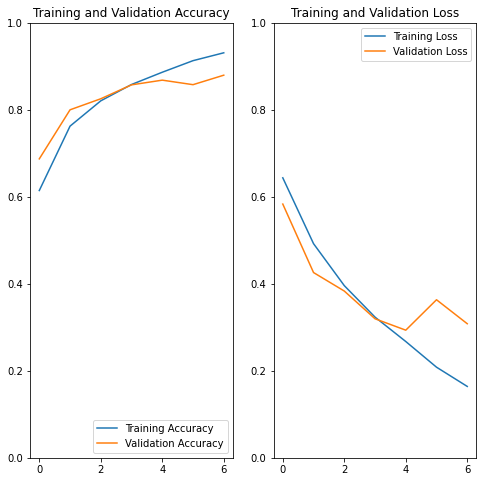

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.gca().set_ylim(0,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.gca().set_ylim(0,1)
plt.show()

In [85]:
probability_model_3 = tf.keras.Sequential([model3, tf.keras.layers.Softmax()])

In [86]:
ypred3 = probability_model_3.predict(X_val)

In [87]:
ypred3_list = []
for i in range(0, len(ypred3)):
    ypred3_list.append(np.argmax(ypred3[i]))

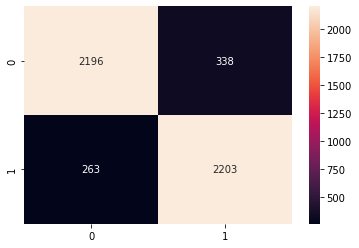

In [88]:
# confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), ypred3_list)
sns.heatmap(cm, annot=True, fmt='d')

In [89]:
print(classification_report(np.argmax(y_val, axis=1), ypred3_list))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2534
           1       0.87      0.89      0.88      2466

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [90]:
# test predictions
test_pred3 = probability_model_3.predict(X_test)

In [91]:
test_pred3_list = []
for i in range(0, len(test_pred3)):
    test_pred3_list.append(test_pred3[i][0])

In [92]:
Id = []
for i in range(1, len(test_pred3_list) + 1):
    Id.append(i)

m3_sub = pd.DataFrame(list(zip(Id, test_pred3_list)), columns = ['id', 'label'])
m3_sub.to_csv('submission3.csv', index = False)
files.download('submission3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

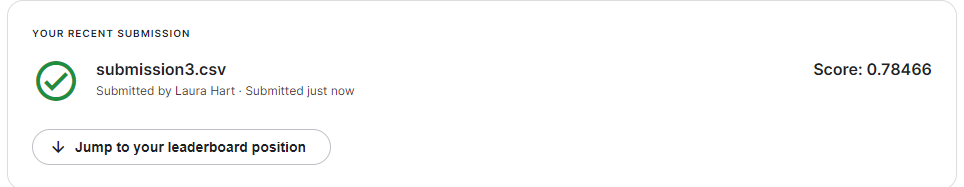